<a href="https://colab.research.google.com/github/Alamsyah-WM/Classification-DBP-Binding-vs-Non-Binding/blob/Minggu3/Minggu3_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup


---


Installing packages pandas, numpy, tqdm, sckit-learn, and pretrain model

In [ ]:
!pip install fair-esm -q
!pip install torch torchvision torchaudio
!pip install fair-esm scikit-learn pandas numpy tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 8.2 MB/s eta 0:00:00


#Import Library


---


Importing Library from installed setup

In [ ]:
import torch
import pandas as pd
import numpy as np
import esm
import os
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import time
import itertools
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score, classification_report,
    matthews_corrcoef
)
import matplotlib.pyplot as plt

In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#Load Dataset
---
Load both PDB1063 and UniSwiss dataset.

> df_pdb = pd.read_csv(pdb_dataset_path) <p> df_uni = pd.read_csv(uni_dataset_path) </p>




In [ ]:
df_pdb = pd.read_csv('/content/PDB1063-186.csv')
df_uni = pd.read_csv('/content/UniSwiss.csv')


print(f'Total sequence PDB: {len(df_pdb)}')
print(f'Total sequence UniSwiss: {len(df_uni)}')

Total sequence PDB: 1249
Total sequence UniSwiss: 9762


#Preprocess Dataset
---
Cleaning duplicate sequence (cleaning_dataset)

> df_clean = df.drop_duplicates(subset='sequence')

Split test and train dataset (split_dataset)


> train_df = df[df['set'] == 'train'] <p>
        test_df = df[df['set'] == 'test']




In [ ]:
def cleaning_dataset (df, dataset_name= None):
    if df is None or df.empty:
        print(f'Dataset {dataset_name} is empty. No clean required')
        return df

    # Check if 'set' column exists
    if 'set' in df.columns:
        df_sorted = df.sort_values(by='set', ascending=True)  # 'test' > 'train' alphabetically
        df_clean = df_sorted.drop_duplicates(subset='sequence', keep='first')

        # Reset index
        df_clean = df_clean.reset_index(drop=True)

        # Show statistics
        train_before = len(df[df['set'] == 'train'])
        test_before = len(df[df['set'] == 'test'])
        train_after = len(df_clean[df_clean['set'] == 'train'])
        test_after = len(df_clean[df_clean['set'] == 'test'])

        print(f'Dataset {dataset_name}:')
        print(f'  Train: {train_before} -> {train_after} (removed {train_before - train_after})')
        print(f'  Test: {test_before} -> {test_after} (removed {test_before - test_after})')
        print(f'  Total: {len(df)} -> {len(df_clean)} (removed {len(df) - len(df_clean)})')
    else:
        # If no 'set' column, just remove duplicates normally
        df_clean = df.drop_duplicates(subset='sequence', keep='first')
        print(f'Total protein dataset {dataset_name} after cleaning: {len(df_clean)}')

    return df_clean

df_pdb = cleaning_dataset(df_pdb, "PDB")
df_uni = cleaning_dataset(df_uni, "UniSwiss")


def split_dataset (df, dataset_name= None):
    if 'set' in df.columns:
        train_df = df[df['set'] == 'train']
        test_df = df[df['set'] == 'test']
    else:
        return df

    # Extract seq and labels for both dataset
    x_train = train_df['sequence'].tolist()
    y_train = train_df['label'].values

    x_test = test_df['sequence'].tolist()
    y_test = test_df['label'].values

    print(f"\nTraining sequence {dataset_name}: {len(x_train)}")
    print(f"Training label {dataset_name}: {len(y_train)}")

    print(f"Test sequence {dataset_name}: {len(x_test)}")
    print(f"Test label {dataset_name}: {len(y_test)}")

    return train_df, test_df, x_train, y_train, x_test, y_test

df_pdb_train, df_pdb_test, x_pdb_train, y_pdb_train, x_pdb_test, y_pdb_test = split_dataset(df_pdb, 'PDB')
df_uni_train, df_uni_test, x_uni_train, y_uni_train, x_uni_test, y_uni_test = split_dataset(df_uni, 'UniSwiss')


Dataset PDB:
  Train: 1063 -> 985 (removed 78)
  Test: 186 -> 186 (removed 0)
  Total: 1249 -> 1171 (removed 78)
Dataset UniSwiss:
  Train: 9000 -> 8937 (removed 63)
  Test: 762 -> 759 (removed 3)
  Total: 9762 -> 9696 (removed 66)

Training sequence PDB: 985
Training label PDB: 985
Test sequence PDB: 186
Test label PDB: 186

Training sequence UniSwiss: 8937
Training label UniSwiss: 8937
Test sequence UniSwiss: 759
Test label UniSwiss: 759


#Load pretrain model

---


Check device processor for running
>device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Load model ESM-1b
> model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()

call converter/formatter for raw protein sequence into format can be processed by model
> batch_converter = alphabet.get_batch_converter()




In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
batch_converter = alphabet.get_batch_converter()
model = model.eval().to(device)

Using device: cuda
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm1b_t33_650M_UR50S.pt" to /root/.cache/torch/hub/checkpoints/esm1b_t33_650M_UR50S.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm1b_t33_650M_UR50S-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm1b_t33_650M_UR50S-contact-regression.pt


#Sequence Handling

---


Add window sliding for split long protein sequence into overlapping windows. (window_sliding)

If protein sequence length > 1022, split into overlap window (chunks)

In [ ]:
def window_sliding(seq, max_len=1022, stride=512):
    if len(seq) <= max_len:
        return [seq]
    chunks = []
    for i in range(0, len(seq), stride):
        chunk = seq[i:i + max_len]
        if len(chunk) < 50:   # skip fragments too short to be meaningful
            continue
        chunks.append(chunk)
    return chunks

#Embeddings

---
Extract mean ESM-1b embeddings for a list of protein sequences (extract_esm_embeddings).

In [ ]:
def extract_esm_embeddings(sequences, batch_size=8):
    """Extract mean ESM-1b embeddings with automatic windowing for long proteins."""
    all_embeddings = []
    truncated_count = 0

    for seq in tqdm(sequences, desc="Extracting ESM embeddings"):
        subseqs = window_sliding(seq)
        if len(seq) > 1022 :
            truncated_count += 1

        subseq_embeddings = []
        for i in range(0, len(subseqs), batch_size):
            batch = subseqs[i:i + batch_size]
            batch_data = [("", s) for s in batch]
            batch_labels, batch_strs, batch_tokens = batch_converter(batch_data)
            batch_tokens = batch_tokens.to(device)

            with torch.no_grad():
                results = model(batch_tokens, repr_layers=[33])
                reps = results["representations"][33]

            for j, s in enumerate(batch):
                emb = reps[j, 1:len(s)+1].mean(0).cpu().numpy()
                subseq_embeddings.append(emb)

            del batch_tokens, results, reps
            torch.cuda.empty_cache()

        # Average all windows for this protein
        mean_embedding = np.mean(subseq_embeddings, axis=0)
        all_embeddings.append(mean_embedding)

    print(f"Total sequences processed: {len(sequences)}")
    print(f"Sequences truncated (>1022 aa): {truncated_count} ({truncated_count/len(sequences)*100:.2f}%)")

    return np.vstack(all_embeddings)

x_pdb_train_emb = extract_esm_embeddings(x_pdb_train, batch_size=8)
x_pdb_test_emb  = extract_esm_embeddings(x_pdb_test, batch_size=8)

x_uni_train_emb = extract_esm_embeddings(x_uni_train, batch_size=8)
x_uni_test_emb  = extract_esm_embeddings(x_uni_test, batch_size=8)

Extracting ESM embeddings: 100%|██████████| 985/985 [01:59<00:00,  8.27it/s]


Total sequences processed: 985
Sequences truncated (>1022 aa): 5 (0.51%)


Extracting ESM embeddings: 100%|██████████| 186/186 [00:27<00:00,  6.88it/s]


Total sequences processed: 186
Sequences truncated (>1022 aa): 4 (2.15%)


Extracting ESM embeddings: 100%|██████████| 8937/8937 [46:31<00:00,  3.20it/s]


Total sequences processed: 8937
Sequences truncated (>1022 aa): 735 (8.22%)


Extracting ESM embeddings: 100%|██████████| 759/759 [03:54<00:00,  3.24it/s]

Total sequences processed: 759
Sequences truncated (>1022 aa): 64 (8.43%)


#Checkpoints DL


---


Saving embedding output from pretrained model. <P>
Create directory for Deep Learning model
> os.makedirs("esm_embed/DL", exist_ok=True)

Save sequence train and test (PDB)
>torch.save(torch.tensor(x_pdb_train_emb), "esm_embed/DL/PDB/x_pdb_train.pt")<p>torch.save(torch.tensor(x_pdb_test_emb),  "esm_embed/DL/PDB/x__pdb_test.pt")

Save label train and test (PDB)
> np.save("esm_embed/DL/PDB/y_pdb_train.npy", y_pdb_train) <p>
np.save("esm_embed/DL/PDB/y_pdb_test.npy",  y_pdb_test)

In [ ]:
os.makedirs("esm_embed_2/DL", exist_ok=True)

torch.save(torch.tensor(x_pdb_train_emb), "esm_embed_2/DL/PDB/x_pdb_train.pt")
torch.save(torch.tensor(x_pdb_test_emb),  "esm_embed_2/DL/PDB/x_pdb_test.pt")

np.save("esm_embed_2/DL/PDB/y_pdb_train.npy", y_pdb_train)
np.save("esm_embed_2/DL/PDB/y_pdb_test.npy",  y_pdb_test)

torch.save(torch.tensor(x_uni_train_emb), "esm_embed_2/DL/UNI/x_uni_train.pt")
torch.save(torch.tensor(x_uni_test_emb),  "esm_embed_2/DL/UNI/x_uni_test.pt")

np.save("esm_embed_2/DL/UNI/y_uni_train.npy", y_uni_train)
np.save("esm_embed_2/DL/UNI/y_uni_test.npy",  y_uni_test)

print("Save success")

Save success


#Load Checkpoints
Load embedding process for Deep learning and Machine learning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Deep learning
x_pdb_train_emb = torch.load("/content/drive/MyDrive/esm_embed_2/DL/PDB/x_pdb_train.pt").numpy()
y_pdb_train = np.load("/content/drive/MyDrive/esm_embed_2/DL/PDB/y_pdb_train.npy")

x_pdb_test_emb = torch.load("/content/drive/MyDrive/esm_embed_2/DL/PDB/x_pdb_test.pt").numpy()
y_pdb_test = np.load("/content/drive/MyDrive/esm_embed_2/DL/PDB/y_pdb_test.npy")

x_uni_train_emb = torch.load("/content/drive/MyDrive/esm_embed_2/DL/UNI/x_uni_train.pt").numpy()
y_uni_train = np.load("/content/drive/MyDrive/esm_embed_2/DL/UNI/y_uni_train.npy")

x_uni_test_emb = torch.load("/content/drive/MyDrive/esm_embed_2/DL/UNI/x_uni_test.pt").numpy()
y_uni_test = np.load("/content/drive/MyDrive/esm_embed_2/DL/UNI/y_uni_test.npy")

print (x_pdb_train_emb.shape, y_pdb_train.shape)
print (x_uni_train_emb.shape, y_uni_train.shape)

(985, 1280) (985,)
(8937, 1280) (8937,)


#Split Dataset

In [ ]:
x_pdb_train, x_pdb_val, y_pdb_train, y_pdb_val = train_test_split(
    x_pdb_train_emb, y_pdb_train,
    test_size= 186,
    stratify=y_pdb_train,
    random_state=42
)

# For UniSwiss dataset (use similar logic)
x_uni_train, x_uni_val, y_uni_train, y_uni_val = train_test_split(
    x_uni_train_emb, y_uni_train,
    test_size=759,
    stratify=y_uni_train,
    random_state=42
)

In [ ]:
print(f"PDB New Training set size: {x_pdb_train.shape[0]}")
print(f"PDB Validation set size: {x_pdb_val.shape[0]}")
print(f"PDB Test set size: {x_pdb_test_emb.shape[0]}")

print(f"\nUniSwiss New Training set size: {x_uni_train.shape[0]}")
print(f"UniSwiss Validation set size: {x_uni_val.shape[0]}")
print(f"UniSwiss Test set size: {x_uni_test_emb.shape[0]}")

PDB New Training set size: 799
PDB Validation set size: 186
PDB Test set size: 186

UniSwiss New Training set size: 8178
UniSwiss Validation set size: 759
UniSwiss Test set size: 759


In [ ]:
# PDB
print("PDB - Training Set Class Balance:")
unique, counts = np.unique(y_pdb_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Class {u}: {c}, Percent: {c/len(y_pdb_train)*100:.2f}%")

print("\nPDB - Validation Set Class Balance:")
unique, counts = np.unique(y_pdb_val, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Class {u}: {c}, Percent: {c/len(y_pdb_val)*100:.2f}%")

print("\nPDB - Test Set Class Balance:")
unique, counts = np.unique(y_pdb_test, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Class {u}: {c}, Percent: {c/len(y_pdb_test)*100:.2f}%")

# UniSwiss
print("\nUniSwiss - Training Set Class Balance:")
unique, counts = np.unique(y_uni_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Class {u}: {c}, Percent: {c/len(y_uni_train)*100:.2f}%")

print("\nUniSwiss - Validation Set Class Balance:")
unique, counts = np.unique(y_uni_val, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Class {u}: {c}, Percent: {c/len(y_uni_val)*100:.2f}%")

print("\nUniSwiss - Test Set Class Balance:")
unique, counts = np.unique(y_uni_test, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Class {u}: {c}, Percent: {c/len(y_uni_test)*100:.2f}%")

PDB - Training Set Class Balance:
Class 0: 442, Percent: 55.32%
Class 1: 357, Percent: 44.68%

PDB - Validation Set Class Balance:
Class 0: 103, Percent: 55.38%
Class 1: 83, Percent: 44.62%

PDB - Test Set Class Balance:
Class 0: 93, Percent: 50.00%
Class 1: 93, Percent: 50.00%

UniSwiss - Training Set Class Balance:
Class 0: 4116, Percent: 50.33%
Class 1: 4062, Percent: 49.67%

UniSwiss - Validation Set Class Balance:
Class 0: 382, Percent: 50.33%
Class 1: 377, Percent: 49.67%

UniSwiss - Test Set Class Balance:
Class 0: 381, Percent: 50.20%
Class 1: 378, Percent: 49.80%


#Define Models
Define Bi-LSTM Model


```
class BiLSTMModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout, output_dim):
        super().__init__()
        self.lstm = torch.nn.LSTM(
            input_dim, hidden_dim, batch_first=True, bidirectional=True
        )
        self.dropout = torch.nn.Dropout(dropout)
        self.fc = torch.nn.Linear(hidden_dim * 2, output_dim)  # times 2 for bidirectional

```



    def forward(self, x):
        # Reshape x: [batch_size, input_dim] -> [batch_size, seq_len=1, input_dim]
        x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)  # [batch_size, 1, hidden_dim*2]
        x = self.dropout(lstm_out[:, -1, :])   # last output
        return self.fc(x)  # [batch_size, output_dim]


Set manual hyperparameter loop for find the best Hyperparameter


```
configs = [
    {'hidden_dim': 128, 'dropout': 0.3, 'lr': 0.0005},
    {'hidden_dim': 256, 'dropout': 0.3, 'lr': 0.0005},
    {'hidden_dim': 128, 'dropout': 0.5, 'lr': 0.0005},
    {'hidden_dim': 128, 'dropout': 0.3, 'lr': 0.001},
    {'hidden_dim': 192, 'dropout': 0.4, 'lr': 0.0007}
]
```



In [ ]:
# Example model class - adjust only if your actual class has different arguments!
class BiLSTMModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout, output_dim):
        super().__init__()
        self.lstm = torch.nn.LSTM(
            input_dim, hidden_dim, batch_first=True, bidirectional=True
        )
        self.dropout = torch.nn.Dropout(dropout)
        self.fc = torch.nn.Linear(hidden_dim * 2, output_dim)  # times 2 for bidirectional

    def forward(self, x):
        # Reshape x: [batch_size, input_dim] -> [batch_size, seq_len=1, input_dim]
        x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)  # [batch_size, 1, hidden_dim*2]
        x = self.dropout(lstm_out[:, -1, :])   # last output
        return self.fc(x)  # [batch_size, output_dim]


##PDB Hyperparameter grid


In [ ]:
# -- PDB Hyperparameter grid --
hidden_dims_pdb = [128, 256, 512]
dropouts_pdb = [0.1, 0.3, 0.5]
lrs_pdb = [0.0005, 0.001, 0.002]
batch_sizes_pdb = [16, 32, 64]

grid_pdb = list(itertools.product(hidden_dims_pdb, dropouts_pdb, lrs_pdb, batch_sizes_pdb))

configs_pdb = [
    {'hidden_dim': h, 'dropout': d, 'lr': lr, 'batch_size': bs}
    for h, d, lr, bs in grid_pdb
]
results_pdb = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# PDB dataset loaders (set these up before this block!)
pdb_train_dataset = TensorDataset(torch.tensor(x_pdb_train, dtype=torch.float32), torch.tensor(y_pdb_train, dtype=torch.long))
pdb_val_dataset = TensorDataset(torch.tensor(x_pdb_val, dtype=torch.float32), torch.tensor(y_pdb_val, dtype=torch.long))

# Make sure you use configs_pdb and results_pdb for this block!
for i, config in enumerate(configs_pdb):
    print(f"\nConfig {i+1}/{len(configs_pdb)}: {config}")

    train_loader = DataLoader(pdb_train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(pdb_val_dataset, batch_size=config['batch_size'], shuffle=False)

    model = BiLSTMModel(input_dim=1280, hidden_dim=config['hidden_dim'],
                        dropout=config['dropout'], output_dim=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    criterion = torch.nn.CrossEntropyLoss()
    patience = 5
    best_val_f1 = 0
    best_state = None
    bad_epochs = 0

    # ---- TRACK LOSS ARRAYS HERE ----
    train_losses = []
    val_losses = []

    for epoch in range(1, 31):
        # --- Training ---
        model.train()
        train_loss_epoch = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_loss_epoch += loss.item() * xb.size(0)
        train_loss_epoch = train_loss_epoch / len(train_loader.dataset)
        train_losses.append(train_loss_epoch)

        # --- Validation ---
        model.eval()
        val_loss_epoch = 0.0
        all_preds, all_targets = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)
                val_loss_epoch += loss.item() * xb.size(0)
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_targets.extend(yb.cpu().numpy())
        val_loss_epoch = val_loss_epoch / len(val_loader.dataset)
        val_losses.append(val_loss_epoch)

        val_f1 = f1_score(all_targets, all_preds, average='binary')
        val_acc = accuracy_score(all_targets, all_preds)
        print(f"Epoch {epoch}: TrainLoss = {train_loss_epoch:.4f}, ValLoss = {val_loss_epoch:.4f}, Val Acc = {val_acc:.4f}, Val F1 = {val_f1:.4f}")

        # --- Early Stopping ---
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = model.state_dict()
            bad_epochs = 0
        else:
            bad_epochs += 1
        if bad_epochs >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # --- Log best for summary ---
    results_pdb.append({
        **config,
        'best_val_f1': best_val_f1,
        'train_losses': train_losses,
        'val_losses': val_losses
    })

# --- Find best configuration ---
best_pdb_config = max(results_pdb, key=lambda x: x['best_val_f1'])
print(f"\nBest PDB Config: {best_pdb_config}")



Config 1/81: {'hidden_dim': 128, 'dropout': 0.1, 'lr': 0.0005, 'batch_size': 16}
Epoch 1: TrainLoss = 0.6287, ValLoss = 0.5828, Val Acc = 0.6075, Val F1 = 0.2316
Epoch 2: TrainLoss = 0.4702, ValLoss = 0.3896, Val Acc = 0.8280, Val F1 = 0.8072
Epoch 3: TrainLoss = 0.3491, ValLoss = 0.3416, Val Acc = 0.8441, Val F1 = 0.8343
Epoch 4: TrainLoss = 0.3094, ValLoss = 0.3766, Val Acc = 0.8333, Val F1 = 0.8342
Epoch 5: TrainLoss = 0.2742, ValLoss = 0.3219, Val Acc = 0.8495, Val F1 = 0.8353
Epoch 6: TrainLoss = 0.2566, ValLoss = 0.3332, Val Acc = 0.8441, Val F1 = 0.8343
Epoch 7: TrainLoss = 0.2205, ValLoss = 0.3295, Val Acc = 0.8548, Val F1 = 0.8421
Epoch 8: TrainLoss = 0.1918, ValLoss = 0.3264, Val Acc = 0.8441, Val F1 = 0.8221
Epoch 9: TrainLoss = 0.1816, ValLoss = 0.3962, Val Acc = 0.8172, Val F1 = 0.7606
Epoch 10: TrainLoss = 0.1544, ValLoss = 0.3499, Val Acc = 0.8441, Val F1 = 0.8263
Epoch 11: TrainLoss = 0.1492, ValLoss = 0.3479, Val Acc = 0.8441, Val F1 = 0.8304
Epoch 12: TrainLoss = 0.1

##UniSwiss hyperparameter Grid

In [ ]:
# -- UniSwiss Hyperparameter grid --
hidden_dims_uni = [128, 256, 512]
dropouts_uni = [0.1, 0.3, 0.5]
lrs_uni = [0.0005, 0.001, 0.002]
batch_sizes_uni = [16, 32, 64]

grid_uni = list(itertools.product(hidden_dims_uni, dropouts_uni, lrs_uni, batch_sizes_uni))

configs_uni = [
    {'hidden_dim': h, 'dropout': d, 'lr': lr, 'batch_size': bs}
    for h, d, lr, bs in grid_uni
]
results_uni = []

# Uniswiss dataset loaders (set these up before this block!)
uni_train_dataset = TensorDataset(torch.tensor(x_uni_train, dtype=torch.float32), torch.tensor(y_uni_train, dtype=torch.long))
uni_val_dataset = TensorDataset(torch.tensor(x_uni_val, dtype=torch.float32), torch.tensor(y_uni_val, dtype=torch.long))

# Make sure you use configs_uni and results_uni for this block!
for i, config in enumerate(configs_uni):
    print(f"\nConfig {i+1}/{len(configs_uni)}: {config}")

    train_loader = DataLoader(uni_train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(uni_val_dataset, batch_size=config['batch_size'], shuffle=False)

    model = BiLSTMModel(input_dim=1280, hidden_dim=config['hidden_dim'],
                        dropout=config['dropout'], output_dim=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    criterion = torch.nn.CrossEntropyLoss()
    patience = 5
    best_val_f1 = 0
    best_state = None
    bad_epochs = 0

    # ---- TRACK LOSS ARRAYS HERE ----
    train_losses = []
    val_losses = []

    for epoch in range(1, 31):
        # --- Training ---
        model.train()
        train_loss_epoch = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_loss_epoch += loss.item() * xb.size(0)
        train_loss_epoch = train_loss_epoch / len(train_loader.dataset)
        train_losses.append(train_loss_epoch)

        # --- Validation ---
        model.eval()
        val_loss_epoch = 0.0
        all_preds, all_targets = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)
                val_loss_epoch += loss.item() * xb.size(0)
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_targets.extend(yb.cpu().numpy())
        val_loss_epoch = val_loss_epoch / len(val_loader.dataset)
        val_losses.append(val_loss_epoch)

        val_f1 = f1_score(all_targets, all_preds, average='binary')
        val_acc = accuracy_score(all_targets, all_preds)
        print(f"Epoch {epoch}: TrainLoss = {train_loss_epoch:.4f}, ValLoss = {val_loss_epoch:.4f}, Val Acc = {val_acc:.4f}, Val F1 = {val_f1:.4f}")

        # --- Early Stopping ---
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = model.state_dict()
            bad_epochs = 0
        else:
            bad_epochs += 1
        if bad_epochs >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # --- Log best for summary ---
    results_uni.append({
        **config,
        'best_val_f1': best_val_f1,
        'train_losses': train_losses,
        'val_losses': val_losses
    })

# --- Find best configuration ---
best_uni_config = max(results_uni, key=lambda x: x['best_val_f1'])
print(f"\nBest uni Config: {best_uni_config}")


Config 1/81: {'hidden_dim': 128, 'dropout': 0.1, 'lr': 0.0005, 'batch_size': 16}
Epoch 1: TrainLoss = 0.3569, ValLoss = 0.2680, Val Acc = 0.8972, Val F1 = 0.8982
Epoch 2: TrainLoss = 0.2631, ValLoss = 0.2626, Val Acc = 0.8893, Val F1 = 0.8817
Epoch 3: TrainLoss = 0.2437, ValLoss = 0.2395, Val Acc = 0.8999, Val F1 = 0.8981
Epoch 4: TrainLoss = 0.2317, ValLoss = 0.2947, Val Acc = 0.8762, Val F1 = 0.8848
Epoch 5: TrainLoss = 0.2182, ValLoss = 0.2269, Val Acc = 0.9065, Val F1 = 0.9062
Epoch 6: TrainLoss = 0.2043, ValLoss = 0.2325, Val Acc = 0.9038, Val F1 = 0.9012
Epoch 7: TrainLoss = 0.1942, ValLoss = 0.2314, Val Acc = 0.9038, Val F1 = 0.9015
Epoch 8: TrainLoss = 0.1845, ValLoss = 0.2369, Val Acc = 0.9025, Val F1 = 0.9026
Epoch 9: TrainLoss = 0.1727, ValLoss = 0.2330, Val Acc = 0.9117, Val F1 = 0.9088
Epoch 10: TrainLoss = 0.1655, ValLoss = 0.2502, Val Acc = 0.9078, Val F1 = 0.9036
Epoch 11: TrainLoss = 0.1514, ValLoss = 0.2860, Val Acc = 0.8854, Val F1 = 0.8880
Epoch 12: TrainLoss = 0.1

##Train Models
Retrain model with best Hyperparameter combined Train + Val set

In [ ]:
# Combine train and validation data
train_losses = []
val_losses = []
X_pdb_full = np.concatenate([x_pdb_train, x_pdb_val], axis=0)
y_pdb_full = np.concatenate([y_pdb_train, y_pdb_val], axis=0)

X_train_diag, X_val_diag, y_train_diag, y_val_diag = train_test_split(
    X_pdb_full, y_pdb_full, test_size=0.1, stratify=y_pdb_full, random_state=42
)

train_diag_dataset = TensorDataset(
    torch.tensor(X_train_diag, dtype=torch.float32),
    torch.tensor(y_train_diag, dtype=torch.long)
)
val_diag_dataset = TensorDataset(
    torch.tensor(X_val_diag, dtype=torch.float32),
    torch.tensor(y_val_diag, dtype=torch.long)
)
train_diag_loader = DataLoader(
    train_diag_dataset, batch_size=best_pdb_config['batch_size'], shuffle=True
)
val_diag_loader = DataLoader(
    val_diag_dataset, batch_size=best_pdb_config['batch_size'], shuffle=False
)

# Model for final PDB
model_pdb = BiLSTMModel(
    input_dim=1280,
    hidden_dim=best_pdb_config['hidden_dim'],
    dropout=best_pdb_config['dropout'],
    output_dim=2
).to(device)
optimizer_pdb = torch.optim.Adam(model_pdb.parameters(), lr=best_pdb_config['lr'])
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
val_losses = []

for epoch in range(1, 31):
    # --- Train ---
    model_pdb.train()
    train_loss_epoch = 0.0
    for xb, yb in train_diag_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer_pdb.zero_grad()
        out = model_pdb(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer_pdb.step()
        train_loss_epoch += loss.item() * xb.size(0)
    train_loss_epoch = train_loss_epoch / len(train_diag_loader.dataset)
    train_losses.append(train_loss_epoch)

    # --- Val ---
    model_pdb.eval()
    val_loss_epoch = 0.0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for xb, yb in val_diag_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model_pdb(xb)
            loss = criterion(out, yb)
            val_loss_epoch += loss.item() * xb.size(0)
            preds = torch.argmax(out, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(yb.cpu().numpy())
    val_loss_epoch = val_loss_epoch / len(val_diag_loader.dataset)
    val_losses.append(val_loss_epoch)

    val_f1 = f1_score(all_targets, all_preds, average='binary')
    print(f"Epoch {epoch}: TrainLoss={train_loss_epoch:.4f}, ValLoss={val_loss_epoch:.4f}, ValF1={val_f1:.4f}")



Epoch 1: TrainLoss=0.6009, ValLoss=0.4211, ValF1=0.7179
Epoch 2: TrainLoss=0.3645, ValLoss=0.3845, ValF1=0.7595
Epoch 3: TrainLoss=0.2700, ValLoss=0.4222, ValF1=0.7368
Epoch 4: TrainLoss=0.2306, ValLoss=0.4886, ValF1=0.7848
Epoch 5: TrainLoss=0.2343, ValLoss=0.4615, ValF1=0.8095
Epoch 6: TrainLoss=0.1737, ValLoss=0.4850, ValF1=0.7765
Epoch 7: TrainLoss=0.1413, ValLoss=0.4967, ValF1=0.8421
Epoch 8: TrainLoss=0.1854, ValLoss=0.4848, ValF1=0.8444
Epoch 9: TrainLoss=0.1096, ValLoss=0.8589, ValF1=0.7467
Epoch 10: TrainLoss=0.1245, ValLoss=0.5412, ValF1=0.8222
Epoch 11: TrainLoss=0.0812, ValLoss=0.5947, ValF1=0.8235
Epoch 12: TrainLoss=0.0688, ValLoss=0.7087, ValF1=0.8095
Epoch 13: TrainLoss=0.0612, ValLoss=0.7010, ValF1=0.8352
Epoch 14: TrainLoss=0.0591, ValLoss=0.7143, ValF1=0.8298
Epoch 15: TrainLoss=0.0352, ValLoss=0.7821, ValF1=0.8090
Epoch 16: TrainLoss=0.0315, ValLoss=0.7734, ValF1=0.8261
Epoch 17: TrainLoss=0.0440, ValLoss=0.8248, ValF1=0.7901
Epoch 18: TrainLoss=0.0321, ValLoss=0.81

In [ ]:
# Combine train and validation data
train_losses = []
val_losses = []
X_uni_full = np.concatenate([x_uni_train, x_uni_val], axis=0)
y_uni_full = np.concatenate([y_uni_train, y_uni_val], axis=0)

X_train_diag, X_val_diag, y_train_diag, y_val_diag = train_test_split(
    X_uni_full, y_uni_full, test_size=0.1, stratify=y_uni_full, random_state=42
)

train_diag_dataset = TensorDataset(
    torch.tensor(X_train_diag, dtype=torch.float32),
    torch.tensor(y_train_diag, dtype=torch.long)
)
val_diag_dataset = TensorDataset(
    torch.tensor(X_val_diag, dtype=torch.float32),
    torch.tensor(y_val_diag, dtype=torch.long)
)
train_diag_loader = DataLoader(
    train_diag_dataset, batch_size=best_uni_config['batch_size'], shuffle=True
)
val_diag_loader = DataLoader(
    val_diag_dataset, batch_size=best_uni_config['batch_size'], shuffle=False
)

# Model for final uni
model_uni = BiLSTMModel(
    input_dim=1280,
    hidden_dim=best_uni_config['hidden_dim'],
    dropout=best_uni_config['dropout'],
    output_dim=2
).to(device)
optimizer_uni = torch.optim.Adam(model_uni.parameters(), lr=best_uni_config['lr'])
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
val_losses = []

for epoch in range(1, 31):
    # --- Train ---
    model_uni.train()
    train_loss_epoch = 0.0
    for xb, yb in train_diag_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer_uni.zero_grad()
        out = model_uni(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer_uni.step()
        train_loss_epoch += loss.item() * xb.size(0)
    train_loss_epoch = train_loss_epoch / len(train_diag_loader.dataset)
    train_losses.append(train_loss_epoch)

    # --- Val ---
    model_uni.eval()
    val_loss_epoch = 0.0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for xb, yb in val_diag_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model_uni(xb)
            loss = criterion(out, yb)
            val_loss_epoch += loss.item() * xb.size(0)
            preds = torch.argmax(out, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(yb.cpu().numpy())
    val_loss_epoch = val_loss_epoch / len(val_diag_loader.dataset)
    val_losses.append(val_loss_epoch)

    val_f1 = f1_score(all_targets, all_preds, average='binary')
    print(f"Epoch {epoch}: TrainLoss={train_loss_epoch:.4f}, ValLoss={val_loss_epoch:.4f}, ValF1={val_f1:.4f}")



Epoch 1: TrainLoss=0.3548, ValLoss=0.2850, ValF1=0.8896
Epoch 2: TrainLoss=0.2758, ValLoss=0.3178, ValF1=0.8635
Epoch 3: TrainLoss=0.2604, ValLoss=0.2844, ValF1=0.8884
Epoch 4: TrainLoss=0.2435, ValLoss=0.2730, ValF1=0.8899
Epoch 5: TrainLoss=0.2320, ValLoss=0.3014, ValF1=0.8875
Epoch 6: TrainLoss=0.2235, ValLoss=0.2709, ValF1=0.9023
Epoch 7: TrainLoss=0.2134, ValLoss=0.2647, ValF1=0.8984
Epoch 8: TrainLoss=0.2076, ValLoss=0.2641, ValF1=0.9027
Epoch 9: TrainLoss=0.2004, ValLoss=0.2699, ValF1=0.9024
Epoch 10: TrainLoss=0.1820, ValLoss=0.2687, ValF1=0.9014
Epoch 11: TrainLoss=0.1836, ValLoss=0.2639, ValF1=0.9051
Epoch 12: TrainLoss=0.1768, ValLoss=0.2983, ValF1=0.8872
Epoch 13: TrainLoss=0.1724, ValLoss=0.2769, ValF1=0.8975
Epoch 14: TrainLoss=0.1591, ValLoss=0.3180, ValF1=0.8839
Epoch 15: TrainLoss=0.1547, ValLoss=0.2946, ValF1=0.9051
Epoch 16: TrainLoss=0.1455, ValLoss=0.2923, ValF1=0.8969
Epoch 17: TrainLoss=0.1361, ValLoss=0.3100, ValF1=0.9019
Epoch 18: TrainLoss=0.1298, ValLoss=0.30


PDB Test Metrics:
  Accuracy     : 0.8172
  Precision    : 0.8391
  Recall/Sens. : 0.7849
  Specificity  : 0.8495
  F1-score     : 0.8111
  MCC          : 0.6357
  ROC_AUC      : 0.9106
  Confusion Matrix:
[[79 14]
 [20 73]]

PDB Test Classification Report:
              precision    recall  f1-score   support

           0     0.7980    0.8495    0.8229        93
           1     0.8391    0.7849    0.8111        93

    accuracy                         0.8172       186
   macro avg     0.8185    0.8172    0.8170       186
weighted avg     0.8185    0.8172    0.8170       186



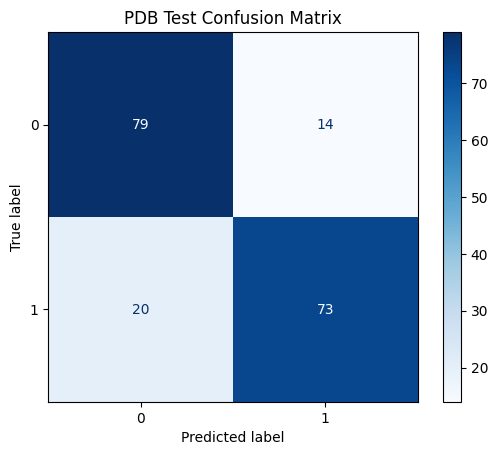

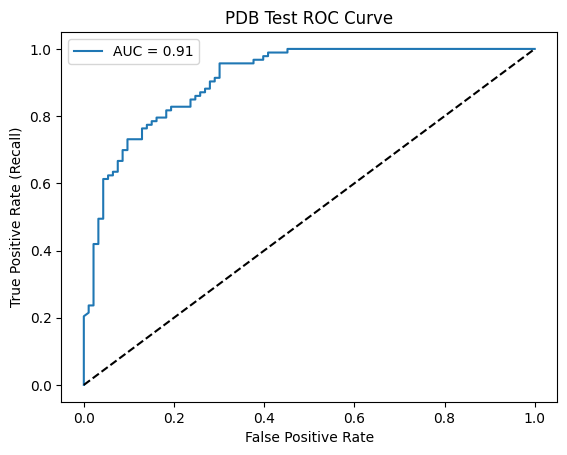

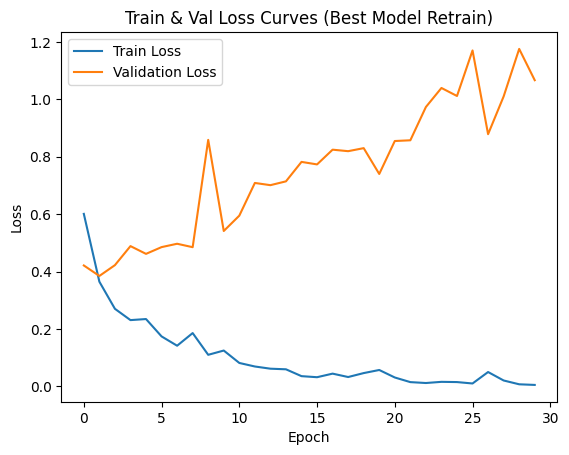

NameError: name 'best_uni_config' is not defined

In [ ]:
def evaluate_and_report(model, loader, name, return_probs=False):
    model.eval()
    all_preds, all_targets = [], []
    all_probs = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            probs = torch.softmax(outputs, dim=1)[:,1].cpu().numpy()  # For binary
            preds = np.round(probs)
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_targets.extend(yb.cpu().numpy())

    acc = accuracy_score(all_targets, all_preds)
    prec = precision_score(all_targets, all_preds)
    rec = recall_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)
    mcc = matthews_corrcoef(all_targets, all_preds)
    cm = confusion_matrix(all_targets, all_preds)

    # Sensitivity == Recall; Specificity == True Negative Rate
    tn, fp, fn, tp = cm.ravel()
    sensitivity = rec
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # ROC/AUC
    roc_auc = roc_auc_score(all_targets, all_probs)
    fpr, tpr, thresholds = roc_curve(all_targets, all_probs)

    print(f"\n{name} Metrics:")
    print(f"  Accuracy     : {acc:.4f}")
    print(f"  Precision    : {prec:.4f}")
    print(f"  Recall/Sens. : {sensitivity:.4f}")
    print(f"  Specificity  : {specificity:.4f}")
    print(f"  F1-score     : {f1:.4f}")
    print(f"  MCC          : {mcc:.4f}")
    print(f"  ROC_AUC      : {roc_auc:.4f}")
    print(f"  Confusion Matrix:\n{cm}\n")
    print(f"{name} Classification Report:")
    print(classification_report(all_targets, all_preds, digits=4))

    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title(f'{name} ROC Curve')
    plt.legend()
    plt.show()

    # Plot val loss
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train & Val Loss Curves (Best Model Retrain)')
    plt.legend()
    plt.show()

    # Optionally return probabilities for further analysis
    if return_probs:
        return all_preds, all_targets, all_probs

    # For report table (like image): print markdown or as pandas.DataFrame
    metrics = {
        "Accuracy": acc,
        "Precision_macro": prec,
        "Recall_macro": rec,
        "F1_macro": f1,
        "MCC": mcc,
        "Specificity": specificity,
        "ROC_AUC": roc_auc
    }
# Run evaluation ONLY on test set for final results
pdb_test_dataset = TensorDataset(torch.tensor(x_pdb_test_emb, dtype=torch.float32), torch.tensor(y_pdb_test, dtype=torch.long))
pdb_test_loader = DataLoader(pdb_test_dataset, batch_size=best_pdb_config['batch_size'], shuffle=False)

evaluate_and_report(model_pdb, pdb_test_loader, "PDB Test")

uni_test_dataset = TensorDataset(torch.tensor(x_uni_test_emb, dtype=torch.float32), torch.tensor(y_uni_test, dtype=torch.long))
uni_test_loader = DataLoader(uni_test_dataset, batch_size=best_uni_config['batch_size'], shuffle=False)

evaluate_and_report(model_uni, uni_test_loader, "UniSwiss Test")



In [ ]:
os.makedirs('saved_models', exist_ok=True)

# Save PDB model
torch.save({
    'model_state_dict': model_pdb.state_dict(),
    'config': {
        'input_dim': 1280,
        'hidden_dim': best_pdb_config['hidden_dim'],
        'dropout': best_pdb_config['dropout'],
        'output_dim': 2
    },
    'hyperparameters': {
        'learning_rate': best_pdb_config['lr'],
        'batch_size': best_pdb_config['batch_size']
    },
    'best_val_f1': best_pdb_config['best_val_f1']
}, 'saved_models/bilstm_pdb.pt')

print("✓ PDB BiLSTM model saved!")


# Save UniSwiss model
# torch.save({
#     'model_state_dict': model_uni.state_dict(),
#     'config': {
#         'input_dim': 1280,
#         'hidden_dim': bestuni_config['hiddendim'],
#         'dropout': bestuni_config['dropout'],
#         'output_dim': 2
#     },
#     'hyperparameters': {
#         'learning_rate': bestuni_config['lr'],
#         'batch_size': bestuni_config['batchsize']
#     },
#     'best_val_f1': bestuni_config['bestvalf1']
# }, 'saved_models/bilstm_uniswiss.pt')

# print("✓ UniSwiss BiLSTM model saved!")


✓ PDB BiLSTM model saved!
